In [2]:
import itertools

import numpy as np
import scipy.stats
import scipy.interpolate

import matplotlib.pyplot as plt
import matplotlib.cm
import matplotlib.transforms
import math
%matplotlib inline

import fklab.geometry.shapes

In [3]:
from data_analysis import loading

In [4]:
loading.load_project('/media/kasia/K/Neuropixeldata/LS_k_5/catgt_14032020-b0_g0')
loading.load_cluster()
ls_data = loading.cluster_data
loading.load_position('/media/kasia/K/Neuropixeldata/LS_k_5/2020-03-14_13-02-19/epochs/training/position.hdf5')
loading.load_position_yaml()
loading.load_environment_yaml()
loading.load_kilosort()
loading.load_event('/media/kasia/K/Neuropixeldata/LS_k_5/2020-03-14_13-02-19/Events.nev',)

In [5]:
Fs = 3000
time_shift = -6.439110058088235
position_time = np.array(loading.position_time)
corrected_time = position_time + time_shift

In [6]:
#loading spiking data
project_root = '/media/kasia/K/Neuropixeldata/LS_k_5/catgt_14032020-b0_g0/'

clusters = np.load(project_root + "spike_clusters.npy")
# print(clusters)
spike_times = np.load(project_root + "spike_times.npy") / Fs
#print(spike_times)
spike_templates = np.load(project_root + "templates.npy")

y_coords = np.load(project_root + "channel_positions.npy")
#print(y_coords)
spike_clusters = np.load(project_root + "spike_clusters.npy")

In [7]:
#loading clusters 
dtype = np.dtype([
    ('id', np.int),
    ('Amplitude', np.float),
    ('ContamPct', np.float),
    ('KSLabel', np.dtype('U5')),
    ('amp', np.float),
    ('channel', np.int),
    ('depth', np.float),
    ('firing_rate', np.float),
    ('group', np.dtype('U5')),
    ('n_spikes', np.int),
    ('shank', np.int),
])

data = np.loadtxt(project_root + "cluster_info.tsv",
                 dtype=dtype, skiprows=1, delimiter='\t',
                 converters={7:lambda fr: fr.replace(b' spk/s', b'')})
#print(data[data['KSLabel'] == 'good'])
# data_good = data[data['KSLabel']== 'good']
data_good = data[data['group'] == 'good']

In [8]:
depth = data_good['depth']
n_spk = data_good['n_spikes']
id_s = data_good['id']
channel= data_good['channel']
print(depth, id_s)

[ 280.  420.  660.  700.  800. 1000. 1040. 1160. 1180. 1220. 1220. 1240.
 1460. 1480. 1500. 1520. 1600. 1620. 1640. 3020. 3180. 3380. 3420. 3600.
 3620. 3660. 3660. 3680. 3680. 3700. 3800.  400. 1040. 1040. 1480. 1580.
 1780. 3580. 3580. 3600. 3680. 3660. 1040. 1240. 3660. 3660. 3660. 3740.
 3660.] [  2   3   4   5   6   9  10  19  20  26  27  29  47  49  51  53  59  61
  62  84  90  95  96 107 110 112 123 125 130 133 137 142 143 144 155 160
 165 175 176 177 181 182 184 186 191 192 193 198 203]


In [9]:
import pandas as pd
channel_cluster = []
channel_label = []
depth = []

for cluster_index, cluster_id in enumerate(id_s):
    channel_cluster.append(str(cluster_id)) 
    channel_label.append(str(channel[cluster_index]))
    
    
cluster_channel = pd.DataFrame({'cluster':channel_cluster,'channel':channel_label})    

# print(cluster_channel)
cluster_channel.to_csv('Cluster_channel_LS_K_5_140320.tsv', sep = '\t')

In [10]:
epoch = loading.position_yaml['source']['epoch']
epoch
open_field_epoch = [4231, 6108]
Y_maze_epoch = [2517, 4185]

In [11]:
from fklab.geometry.shapes import graph, polyline
Y_maze_data = loading.environment_yaml['AT']['shapes']['AT']['shape']
Y_maze_data['polylines'] = [polyline(**p) if not isinstance(p, polyline) else p for p in Y_maze_data['polylines']]
ymaze = graph(**Y_maze_data)

In [12]:
position_at = loading.position[np.logical_and(corrected_time > Y_maze_epoch[0],
                                      corrected_time < Y_maze_epoch[1]), :]
position_at_cm = position_at * 0.27

position_of = loading.position[np.logical_and(corrected_time > open_field_epoch[0],
                                      corrected_time < open_field_epoch[1]), :]
position_of_cm = position_of * 0.27

In [81]:
data = dict(
    vel_bins = [0,2,4,6,8,10,12,14,16, 18, 20]
)
v_bins =  [0,2,4,6,8,10,12,14, 16, 18, 20]

In [82]:
import pandas as pd
cluster_channel = pd.read_csv('/media/kasia/K/Neuropixeldata/data_analysis/Cluster_channel_LS_K_5_140320.tsv', sep='\t')
ks_spike_times = loading.ks_spike_times[:,0]
spike_time_rangeat = np.array(Y_maze_epoch) - loading.evt_start_time[1] + time_shift
t_at = corrected_time[np.logical_and(corrected_time > Y_maze_epoch[0], corrected_time < Y_maze_epoch[1])]
linear_posat = ymaze.point2path(position_at_cm)[0]

In [83]:
spike_t = {}
for cl in cluster_channel['cluster']:
    spike_xat = ks_spike_times[loading.get_spike_seq(spike_time_rangeat, cluster_list=[cl] )] + loading.evt_start_time[1]

    spike_t[cl]=spike_xat

[Text(0.5, 1.0, 'Firing rate as function of speed: NeuronID:2')]

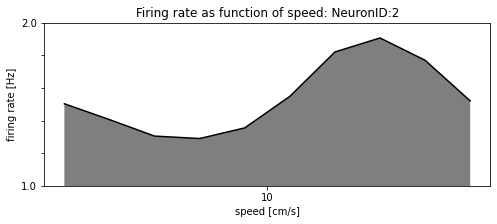

In [193]:
from fklab.behavior.preprocessing import compute_velocity
import fklab.ratemap as rm
from fklab.plot.plots import plot_2d_maps
from fklab.spikes.simulation import linear_speed_tuning
from fklab.signals.smooth import kernelsmoothing
import fklab.signals.smooth as smooth

#time (an array)
# t_at = corrected_time[np.logical_and(corrected_time > Y_maze_epoch[0], corrected_time < Y_maze_epoch[1])]
# mask = ~np.logical_or(np.isnan(position_at_cm[:,0]), np.isnan(position_at_cm[:,1]))
# position = scipy.interpolate.interp1d(t_at[mask], position_at_cm[mask], axis=0, bounds_error=False, assume_sorted=True)(t_at)
# velocity = compute_velocity(position, dx=1/25, smooth=2)
# velocity_xy = np.zeros((len(velocity), 2))
# velocity_xy[:, 0] = velocity.real
# velocity_xy[:, 1] = velocity.imag
# accelerate = compute_velocity(velocity_xy, dx=1/25, smooth=2)
# speedat=np.abs(velocity)
# plt.plot(t_at, np.abs(velocity))
# plt.plot(t_at, np.abs(accelerate))

dt = 1/25
#computing speed for Y_maze in 2D
mask = ~np.logical_or(np.isnan(position_at_cm[:,0]), np.isnan(position_at_cm[:,1]))
t_atr = t_at[mask]
velocity = compute_velocity(position_at_cm[mask], dx=dt, smooth=2)
speedat = np.abs(velocity)
dv = np.diff(velocity)
acc_at = dv / dt

# speed_good = np.delete(speedat,  np.where(speedat >= 60))
# speed_good = np.delete(speed_good1, np.where(speed_good1 <= 10))
# t_c =np.delete(t_atr, np.where(speedat >= 60))
# t_c = np.delete(t_c1, np.where(speed_good1 <= 10))

#firing rate a function of speed


ratemap, spikecount, occ, grid = rm.hist.general_tuning(
    spike_t[26], stimdata=speedat, t=t_atr, dt=dt, bins=[data['vel_bins']], smooth=[2])



fig, axes = fklab.plot.plots.plot_1d_maps(
    ratemap, x=grid[0],
    grid=(None), figsize=(8,3), roundto=1,
    xlabel='speed [cm/s]', ylabel='firing rate [Hz]')

axes[0,0].set_xticks(np.linspace(0.0, 40.0, num=5))
# plt.xticks(np.arange(min(speed_good), max(speed_good), 1.0))
axes[0,0].autoscale(enable=True, axis='x', tight=False) 
axes[0,0].set(title='Firing rate as function of speed: NeuronID:2')
# plt.text(12, 27, 'Pearsons correlation: %.3f' % corr)
# plt.savefig("Firingratevsspeed_2_140320.png")

/home/kasia/miniconda3/envs/fklab/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


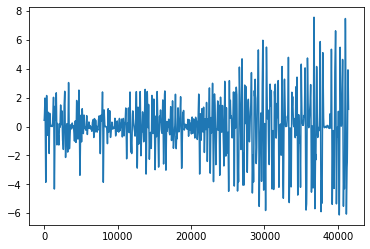

In [80]:
plt.plot(acc_at)

0.053851034547502605
coefficient of determination: 0.3893443836141314
intercept: 1.3379529743947243
slope: [0.0227203]


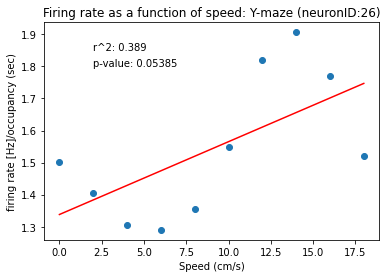

In [195]:
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from scipy import stats

ratemap[0] = [0 if math.isnan(x) else x for x in ratemap[0]]
x = np.array([v_bins[:-1]]).reshape((-1, 1))
y = ratemap[0]
model = LinearRegression()
model.fit(x, y)
model = LinearRegression().fit(x, y)
r_sq = model.score(x, y)
y_pred = model.predict(x)
X2 = sm.add_constant(x)
est = sm.OLS(y, X2)
print(est.fit().f_pvalue)

print('coefficient of determination:', r_sq)
print('intercept:', model.intercept_)
print('slope:', model.coef_)
plt.scatter(x, y)
plt.plot(x, y_pred, color='red')
plt.xlabel("Speed (cm/s)")
plt.ylabel("firing rate [Hz]/occupancy (sec)")
plt.title("Firing rate as a function of speed: Y-maze (neuronID:26)")
plt.text(2,1.85, 'r^2: %.3f' % r_sq)
plt.text(2,1.8, 'p-value: %.5f' %est.fit().f_pvalue)
plt.savefig("ATFiringvsspeed_26_140320.png")
plt.show()

In [26]:
#computing speed for open_field

t_of = corrected_time[np.logical_and(corrected_time > open_field_epoch[0], corrected_time < open_field_epoch[1])]
mask = ~np.logical_or(np.isnan(position_of_cm[:,0]), np.isnan(position_of_cm[:,1]))
t_ofr = t_of[mask]

dt=1/25
velocityof = compute_velocity(position_of_cm[mask], dx = dt, smooth=2)
speedof = np.abs(velocityof)

# speed_goodof = np.delete(speedof,  np.where(speedof >= 60))
# speed_good = np.delete(speed_good1, np.where(speed_good1 <= 10))
# t_cof =np.delete(t_ofr, np.where(speedof >= 60))

spike_time_rangeof = np.array(open_field_epoch) - loading.evt_start_time[1] + time_shift
spike_tof = {}
for cl in cluster_channel['cluster']:
    spike_xof = ks_spike_times[loading.get_spike_seq(spike_time_rangeof, cluster_list=[cl] )] + loading.evt_start_time[1]

    spike_tof[cl]=spike_xof

ratemapof, spikecountof, occof, gridof = rm.hist.general_tuning(
    spike_tof[2], stimdata=speedof, t=t_ofr, dt=dt, bins=[data['vel_bins']], smooth=[2])





In [31]:
print(max(speedof))

21.625745321533305


0.7705442664458597
coefficient of determination: 0.011252906303751642
intercept: 8.323670215691891
slope: [-0.00098288]


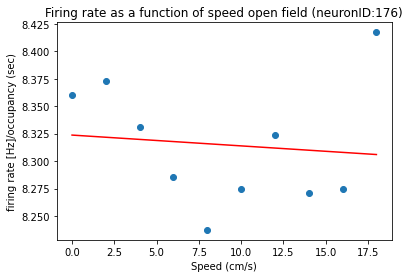

In [28]:
ratemapof[0] = [0 if math.isnan(x) else x for x in ratemapof[0]]

x = np.array([v_bins[:-1]]).reshape((-1, 1))
y = ratemapof[0]
model = LinearRegression()
model.fit(x, y)
model = LinearRegression().fit(x, y)
r_sq = model.score(x, y)
y_pred = model.predict(x)
X2 = sm.add_constant(x)
est = sm.OLS(y, X2)
print(est.fit().f_pvalue)

print('coefficient of determination:', r_sq)
print('intercept:', model.intercept_)
print('slope:', model.coef_)
plt.scatter(x, y)
plt.plot(x, y_pred, color='red')
plt.xlabel("Speed (cm/s)")
plt.ylabel("firing rate [Hz]/occupancy (sec)")
plt.title("Firing rate as a function of speed open field (neuronID:176)")
# plt.text(5, 13.3, 'r^2: %.3f' % r_sq)
# plt.text(5, 13.2, 'p-value: %.5f' %est.fit().f_pvalue)
plt.savefig("OFFiringvsspeed_176_140320.png")
plt.show()

In [164]:
1/20


0.05